In [1]:
"""RandOm Convolutional KErnel Transform (Rocket).

Pipeline classifier using the ROCKET transformer and an sklearn classifier.
"""

__maintainer__ = []
__all__ = ["RocketClassifier"]

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.convolution_based import (
    MiniRocket,
    MultiRocket,
    Rocket,
)


class RocketClassifier(BaseClassifier):
    """
    Classifier wrapped for the Rocket transformer using RidgeClassifierCV.

    This classifier simply transforms the input data using a Rocket [1,2,3]_
    transformer, performs a Standard scaling and fits a sklearn classifier,
    using the transformed data (default classifier is RidgeClassifierCV).

    The classifier can be configured to use Rocket [1]_, MiniRocket [2]_ or
    MultiRocket [3]_.

    Parameters
    ----------
    num_kernels : int, default=10,000
        The number of kernels for the Rocket transform.
    rocket_transform : str, default="rocket"
        The type of Rocket transformer to use.
        Valid inputs = ["rocket", "minirocket", "multirocket"].
    max_dilations_per_kernel : int, default=32
        MiniRocket and MultiRocket only. The maximum number of dilations per kernel.
    n_features_per_kernel : int, default=4
        MultiRocket only. The number of features per kernel.
    estimator : sklearn compatible classifier or None, default=None
        The estimator used. If None, a RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        The number of classes.
    classes_ : list
        The classes labels.

    See Also
    --------
    Rocket
        Rocket transformers are in transformations/collection.
    RocketRegressor

    References
    ----------
    .. [1] Dempster, A., Petitjean, F. and Webb, G.I., 2020. ROCKET: exceptionally fast
        and accurate time series classification using random convolutional kernels.
        Data Mining and Knowledge Discovery, 34(5), pp.1454-1495.
    .. [2] Dempster, A., Schmidt, D.F. and Webb, G.I., 2021, August. Minirocket: A very
        fast (almost) deterministic transform for time series classification. In
        Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data
        mining (pp. 248-257).
    .. [3] Tan, C.W., Dempster, A., Bergmeir, C. and Webb, G.I., 2022. MultiRocket:
        multiple pooling operators and transformations for fast and effective time
        series classification. Data Mining and Knowledge Discovery, 36(5), pp.1623-1646.

    Examples
    --------
    >>> from aeon.classification.convolution_based import RocketClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RocketClassifier(num_kernels=500)
    >>> clf.fit(X_train, y_train)
    RocketClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multithreading": True,
        "capability:multivariate": True,
        "algorithm_type": "convolution",
    }

    def __init__(
        self,
        num_kernels=20000,
        rocket_transform="rocket",
        max_dilations_per_kernel=32,
        n_features_per_kernel=4,
        estimator=None,
        class_weight=None,
        n_jobs=1,
        random_state=None,
    ):
        self.num_kernels = num_kernels
        self.rocket_transform = rocket_transform
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.n_features_per_kernel = n_features_per_kernel
        self.estimator = estimator

        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.random_state = random_state

        super().__init__()

    def _fit(self, X, y):
        """Fit Rocket variant to training data.

        Parameters
        ----------
        X : 3D np.ndarray
            The training data of shape = (n_cases, n_channels, n_timepoints).
        y : 3D np.ndarray
            The class labels, shape = (n_cases,).

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_" and sets is_fitted flag to True.
        """
        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        rocket_transform = self.rocket_transform.lower()
        if rocket_transform == "rocket":
            self._transformer = Rocket(
                num_kernels=self.num_kernels,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "minirocket":
            self._transformer = MiniRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "multirocket":
            self._transformer = MultiRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_features_per_kernel=self.n_features_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        else:
            raise ValueError(f"Invalid Rocket transformer: {self.rocket_transform}")

        self._scaler = StandardScaler(with_mean=False)
        self._estimator = _clone_estimator(
            (
                RidgeClassifierCV(
                    alphas=np.logspace(-3, 3, 10), class_weight=self.class_weight
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        self.pipeline_ = make_pipeline(
            self._transformer,
            self._scaler,
            self._estimator,
        )
        self.pipeline_.fit(X, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = (n_cases,)
            Predicted class labels.
        """
        return self.pipeline_.predict(X)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predict probabilities for.

        Returns
        -------
        y : array-like, shape = (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self.pipeline_.predict_proba(X)
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self.pipeline_.predict(X)
            for i in range(0, X.shape[0]):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            RocketClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
            `create_test_instance` uses the first (or only) dictionary in `params`.
        """
        if parameter_set == "results_comparison":
            return {"num_kernels": 100}
        else:
            return {"num_kernels": 20}

In [2]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.datasets import load_unit_test
from sklearn.metrics import accuracy_score

class RocketClassifierWithPCS(RocketClassifier):
    """
    RocketClassifier extended to include Principal Component Selection (PCS)
    using PCA on the feature matrix before classification.
    """
    def __init__(
        self,
        num_kernels=100000,
        rocket_transform="rocket",
        max_dilations_per_kernel=32,
        n_features_per_kernel=4,
        n_pcs=20000,  # Number of principal components to keep
        estimator=None,
        class_weight=None,
        n_jobs=1,
        random_state=42,
    ):
        self.n_pcs = n_pcs
        super().__init__(
            num_kernels=num_kernels,
            rocket_transform=rocket_transform,
            max_dilations_per_kernel=max_dilations_per_kernel,
            n_features_per_kernel=n_features_per_kernel,
            estimator=estimator,
            class_weight=class_weight,
            n_jobs=n_jobs,
            random_state=random_state,
        )
    
    def _fit(self, X, y):
        """Fit Rocket variant and PCA to the training data."""
        super()._fit(X, y)  # Call the original RocketClassifier's fit method

        # Apply PCA if n_pcs is specified
        if self.n_pcs is not None:
            self._pca = PCA(n_components=self.n_pcs, random_state=self.random_state)
        else:
            self._pca = PCA(random_state=self.random_state)

        # Transform the Rocket features with PCA

        # [changed] Not require to perform this as this step is involed in self.pipeline_.fit(X, y)
        # rocket_features = self._transformer.transform(X)
        # self._pca.fit(rocket_features)
        # pca_features = self._pca.transform(rocket_features)

        # Update the pipeline to include PCA
        self.pipeline_ = make_pipeline(
            self._transformer,
            self._scaler,
            self._pca,
            self._estimator,
        )

        # [changed] pca_features to X
        self.pipeline_.fit(X, y)

        return self
    
    def _predict(self, X):
        """Predict labels for sequences in X after PCA transformation."""
        # [changed] no need apply them explicitly
        # rocket_features = self._transformer.transform(X)
        # pca_features = self._pca.transform(rocket_features)
        return self.pipeline_.predict(X)

    def _predict_proba(self, X):
        """Predict probabilities for sequences in X after PCA transformation."""
        # [changed]
        # rocket_features = self._transformer.transform(X)
        # pca_features = self._pca.transform(rocket_features)
        return self.pipeline_.predict_proba(X)





In [3]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




### Use this mfcc extraction(from scratch)

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWSV2"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (43537, 99, 13)
Labels array shape: (43537,)


In [5]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [6]:
print(X.shape)

(43537, 13, 99)


In [7]:
print(X_train.shape)

(34829, 13, 99)


In [8]:
clf = RocketClassifierWithPCS(num_kernels=100000, n_pcs=20000, random_state=42)
# clf = RocketClassifierWithPCS(num_kernels=1000, n_pcs=200, random_state=42)

In [9]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

RocketClassifierWithPCS()

In [10]:
param = clf.pipeline_[-1]  

# Counting the number of parameters (coef_ and intercept_)
n_params = param.coef_.size + param.intercept_.size
print(f"Number of parameters: {n_params}")

Number of parameters: 240012


In [ ]:
import numpy as np

# Get the intermediate data from the pipeline after feature extraction and PCA transformation
# Get the transformer part of the pipeline
transformer = clf.pipeline_[0]  # This is the Rocket transformer
scaler = clf.pipeline_[1]       # StandardScaler
pca = clf.pipeline_[2]          # PCA

# Transform the X_test data using the same sequence of operations
X_test_transformed = transformer.transform(X_test)
X_test_scaled = scaler.transform(X_test_transformed)
X_test_pca = pca.transform(X_test_scaled)

# Save the transformed X_test to a file
np.save('X_test_PCA_ROCKET_20K.npy', X_test_pca)

print("Transformed X_test has been saved as 'X_test_PCA_ROCKET_20K.npy'.")


In [12]:
print(X_test_pca.shape)

(5539, 20000)


In [13]:
import numpy as np

# Get the intermediate data from the pipeline after feature extraction and PCA transformation
# Get the transformer part of the pipeline
transformer = clf.pipeline_[0]  # This is the Rocket transformer
scaler = clf.pipeline_[1]       # StandardScaler
pca = clf.pipeline_[2]          # PCA

# Transform the X_test data using the same sequence of operations
X_train_transformed = transformer.transform(X_train)
X_train_scaled = scaler.transform(X_train_transformed)
X_train_pca = pca.transform(X_train_scaled)

# Save the transformed X_test to a file
np.save('X_train_PCA_ROCKET_20K.npy', X_train_pca)

print("Transformed X_train has been saved as 'X_train_PCA_ROCKET_20K.npy'.")


Transformed X_train has been saved as 'X_train_PCA_ROCKET_20K.npy'.


In [14]:
print(X_train_pca.shape)

(22153, 20000)


In [11]:
# Predict on the test set
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.9433853927423059


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.9444311542361223
Recall (macro): 0.9431275069048838
F1 Score (macro): 0.9431748641519765


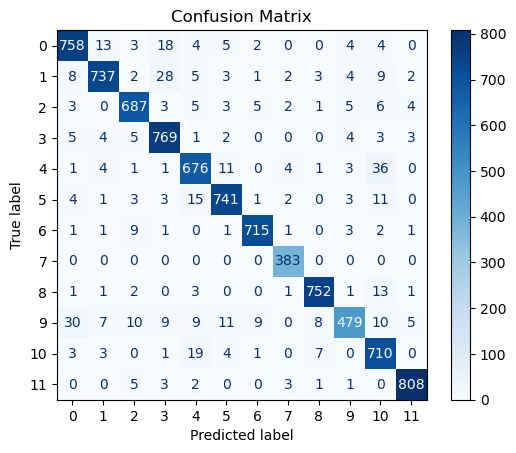

In [13]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [14]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})

Classification Report:
               precision    recall  f1-score   support

        down       0.93      0.93      0.93       811
          go       0.96      0.92      0.94       804
        left       0.94      0.95      0.95       724
          no       0.92      0.97      0.94       796
         off       0.91      0.92      0.92       738
          on       0.95      0.95      0.95       784
       right       0.97      0.97      0.97       735
     silence       0.96      1.00      0.98       383
        stop       0.97      0.97      0.97       775
     unknown       0.94      0.82      0.88       587
          up       0.88      0.95      0.91       748
         yes       0.98      0.98      0.98       823

    accuracy                           0.94      8708
   macro avg       0.94      0.94      0.94      8708
weighted avg       0.94      0.94      0.94      8708

Label mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Example: Define y_test and y_pred
# Replace these with your actual labels
# y_test = [0, 1, 2, 0, 1, 2]  # True labels
# y_pred = [0, 2, 1, 0, 0, 1]  # Predicted labels

# Get the unique classes and binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

n_classes = y_test_bin.shape[1]

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


In [36]:
print(y_pred)

[10  4  5 ...  4  3  8]


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification


n_classes = 12

# Binarize the labels for multiclass precision-recall
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))



# Predict probabilities
y_score = clf.predict_proba(X_test)

# Compute Precision-Recall curves for each class
precision = dict()
recall = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')

# Plot settings
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve (Multiclass)', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


AttributeError: 'RidgeClassifierCV' object has no attribute 'predict_proba'